In [1]:
import glob
import os
import numpy as np
from scipy.io import loadmat

def import_data_signal(root, train_ratio=0.6):
    signals = []
    labels = []
    snr_values = []

    for label_dir, label in [('signal1', 1), ('signal0', 0)]:
        full_dir = os.path.join(root, label_dir)
        if not os.path.exists(full_dir):
            print(f"Directory {full_dir} does not exist.")
            continue

        for filepath in glob.glob(os.path.join(full_dir, '*.mat')):
            try:

                mat_data = loadmat(filepath)

                if 'feature' in mat_data:  
                    signal = mat_data['feature'] 
                else:
                    raise KeyError(f"'feature' key not found in {filepath}. Available keys: {mat_data.keys()}")


                signal = np.array(signal, dtype=np.float32).reshape(64, 4, 1)
                signals.append(signal)
                labels.append(label)


                filename = os.path.basename(filepath) 
                snr_str = filename.split('_')[1]  
                snr = float(snr_str)  
                snr_values.append(snr)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    print(f"Found {len(signals)} signal files.")

    if len(signals) == 0:
        raise ValueError("No signal files found. Check if the directories are correctly named and contain files.")


    combined = list(zip(signals, labels, snr_values))
    np.random.shuffle(combined)
    signals[:], labels[:], snr_values[:] = zip(*combined)


    num_samples = len(signals)
    num_train = int(train_ratio * num_samples)

    train_images = np.array(signals[:num_train])
    train_labels = np.array(labels[:num_train])
    train_snr = np.array(snr_values[:num_train])  

    test_images = np.array(signals[num_train:])
    test_labels = np.array(labels[num_train:])
    test_snr = np.array(snr_values[num_train:])  

   
    class_list = [0, 1]  
    return train_images, train_labels, train_snr, test_images, test_labels, test_snr, class_list


root_dir = 'C:\\Users\\yoyo2\\OneDrive\\桌面\專題\\dl\\dataset'


train_images, train_labels, train_snr, test_images, test_labels, test_snr, class_list = import_data_signal(root_dir)

print(f"Training set size: {len(train_images)}, SNR size: {len(train_snr)}")
print(f"Test set size: {len(test_images)}, SNR size: {len(test_snr)}")

Found 5200 signal files.
Training set size: 3120, SNR size: 3120
Test set size: 2080, SNR size: 2080


In [2]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(class_list)

(3120, 64, 4, 1)
(2080, 64, 4, 1)
(3120,)
(2080,)
[0, 1]


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
from torchsummary import summary

class ConNet(nn.Module):
    def __init__(self):
        super(ConNet, self).__init__()

        self.conv_unit = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=2, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),
            nn.Conv2d(4, 8, kernel_size=2, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),
        )

        self.fc_unit = nn.Sequential(
            nn.Linear(8 * 32 * 2, 128),
            nn.Sigmoid(),
            nn.Linear(128, 84),
            nn.Sigmoid(),
            nn.Linear(84, 48),
            nn.Sigmoid(),
            nn.Linear(48, 2)
        )

    def forward(self, x):
        batchsz = x.size(0)
        x = self.conv_unit(x)
        x = x.view(batchsz, 8 * 32 * 2)
        x = self.fc_unit(x)
        return x

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15, device='cuda'):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {100 * correct / total:.2f}%")


def prepare_dataloader(train_images, train_labels, test_images, test_labels, batch_size=32):

    train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)  # [b, 64, 4, 1] -> [b, 1, 64, 4]
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
    test_labels = torch.tensor(test_labels, dtype=torch.long)


    train_dataset = TensorDataset(train_images, train_labels)
    test_dataset = TensorDataset(test_images, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



train_loader, test_loader = prepare_dataloader(train_images, train_labels, test_images, test_labels)


model = ConNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15, device='cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 64, 4)) 

Epoch [1/15], Loss: 0.6804, Accuracy: 58.14%
Test Loss: 0.6194, Test Accuracy: 73.22%
Epoch [2/15], Loss: 0.5361, Accuracy: 73.27%
Test Loss: 0.4626, Test Accuracy: 73.89%
Epoch [3/15], Loss: 0.4494, Accuracy: 74.26%
Test Loss: 0.4181, Test Accuracy: 76.15%
Epoch [4/15], Loss: 0.4217, Accuracy: 75.03%
Test Loss: 0.4188, Test Accuracy: 75.62%
Epoch [5/15], Loss: 0.4146, Accuracy: 75.54%
Test Loss: 0.4051, Test Accuracy: 74.86%
Epoch [6/15], Loss: 0.3973, Accuracy: 75.45%
Test Loss: 0.3951, Test Accuracy: 76.25%
Epoch [7/15], Loss: 0.3869, Accuracy: 77.60%
Test Loss: 0.3890, Test Accuracy: 75.91%
Epoch [8/15], Loss: 0.3735, Accuracy: 76.73%
Test Loss: 0.3882, Test Accuracy: 76.88%
Epoch [9/15], Loss: 0.3646, Accuracy: 77.60%
Test Loss: 0.3899, Test Accuracy: 76.44%
Epoch [10/15], Loss: 0.3532, Accuracy: 78.72%
Test Loss: 0.3860, Test Accuracy: 76.44%
Epoch [11/15], Loss: 0.3380, Accuracy: 78.43%
Test Loss: 0.3685, Test Accuracy: 78.56%
Epoch [12/15], Loss: 0.3303, Accuracy: 80.13%
Test L

Number of Data: 65
Prediction Time: 0.0740 seconds
Prediction Time per: 0.0011 seconds


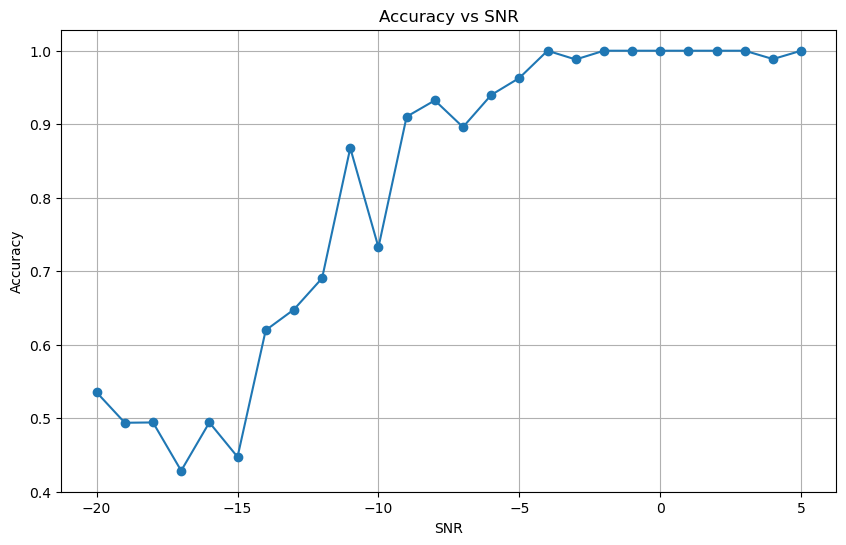

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
device = 'cpu'
import time


class ConNet(nn.Module):
    def __init__(self):
        super(ConNet, self).__init__()

        self.conv_unit = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=2, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),
            nn.Conv2d(4, 8, kernel_size=2, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),
        )

        self.fc_unit = nn.Sequential(
            nn.Linear(8 * 32 * 2, 128),
            nn.Sigmoid(),
            nn.Linear(128, 84),
            nn.Sigmoid(),
            nn.Linear(84, 48),
            nn.Sigmoid(),
            nn.Linear(48, 2)
        )

    def forward(self, x):
        batchsz = x.size(0)
        x = self.conv_unit(x)
        x = x.view(batchsz, 8 * 32 * 2)
        x = self.fc_unit(x)
        return x


def train_and_evaluate(train_loader, test_loader, model, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for inputs, labels, _ in train_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    start_time = time.time()
    
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_snrs = []
    print(f"Number of Data: {len(test_loader)}")
    with torch.no_grad():
        for inputs, labels, snrs in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = outputs.max(1)
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_snrs.append(snrs.numpy())
    test_time = time.time() - start_time
    print(f"Prediction Time: {test_time:.4f} seconds")
    print(f"Prediction Time per: {test_time/len(test_loader):.4f} seconds")
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_snrs = np.concatenate(all_snrs, axis=0)
    return all_predictions, all_labels, all_snrs



def calculate_accuracy_by_snr(predictions, labels, snrs):
    unique_snrs = np.unique(snrs)
    accuracies = []

    for snr in unique_snrs:
        mask = (snrs == snr)
        correct = np.sum(predictions[mask] == labels[mask])
        total = np.sum(mask)
        accuracy = correct / total if total > 0 else 0
        accuracies.append(accuracy)

    return unique_snrs, accuracies


def plot_accuracy_by_snr(snrs, accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(snrs, accuracies, marker='o')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()



train_dataset = TensorDataset(
    torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2),
    torch.tensor(train_labels, dtype=torch.long),
    torch.tensor(train_snr, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2),
    torch.tensor(test_labels, dtype=torch.long),
    torch.tensor(test_snr, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ConNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cpu'  

predictions, labels, snrs = train_and_evaluate(train_loader, test_loader, model, criterion, optimizer, epochs=10, device=device)


unique_snrs, accuracies = calculate_accuracy_by_snr(predictions, labels, snrs)


plot_accuracy_by_snr(unique_snrs, accuracies)